In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
from functools import partial
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
def l21_norm(W):
    # Computes the L21 norm of a symbolic matrix W
    return tf.reduce_sum(tf.norm(W, axis=1))

def group_regularization(v):
    # Computes a group regularization loss from a list of weight matrices corresponding
    # to the different layers
    const_coeff = lambda W: tf.sqrt(tf.cast(W.get_shape().as_list()[1], tf.float32))
    return tf.reduce_sum([tf.multiply(const_coeff(W), l21_norm(W)) for W in v if 'bias' not in W.name])

def group_regularization_player(v):
	const_coeff = lambda W: tf.sqrt(tf.cast(W.get_shape().as_list()[1], tf.float32))
	return tf.reduce_sum(tf.multiply(const_coeff(v), l21_norm(v)))

def custom_group_regularization_player(v, g_scalevec):
	#const_coeff = lambda W: tf.sqrt(tf.cast(W.get_shape().as_list()[1], tf.float32))
	return tf.reduce_sum(tf.multiply(tf.norm(v, axis=1), g_scalevec))

In [ ]:
def friedman_suite(x):
	return 10 * np.sin(np.pi * x[0] * x[1]) + 20 * (x[2] - 0.5)**2 + 10 * x[3] + 5 * x[4]

def get_grd_importance(iXtest):
	nsamples = iXtest.shape[0]
	isum = 0.0
	for i in range(nsamples):
		isum = isum + friedman_suite(iXtest[i, :])
	isum = isum * 1.0 / nsamples
	return isum

def f11_suite(x):
    interaction1 = 10 * np.exp(x[:, 0]*x[:, 1])
    interaction4 = 2 * np.arcsin(x[:, 8] * x[:, 9])
    y=interaction1 + interaction4
    return y

def get_grd_importance_f(iXtest):
	isum = f11_suite(iXtest)
	return np.mean(isum)

def get_grd_importance_f4(iXtest):
	isum = f4_suite(iXtest)
	return np.mean(isum)

In [ ]:
nums = 10
zzelem = 0
ffelem = np.zeros((nums, 1))
sselem = np.zeros((nums, nums))
ttelem = np.zeros((nums, nums, nums))

In [ ]:
def variance_order(tXtest, nums, simu):
	iXtest = tXtest.copy()
	zzelem = simu.eval(feed_dict={X:iXtest})
	ffelem = np.zeros((nums, 1))
	x0 = np.linspace(0, 1, nums)
	for i in range(nums):
		iXtest[:, i] = x0[i] #bug
		ffelem[i] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()
	sselem = np.zeros((nums, nums))
	for i in range(nums):
		iXtest[:, i] = x0[i] #bug
		for j in range(i+1, nums):
			iXtest[:, j] = x0[j]
			sselem[i, j] = simu.eval(feed_dict={X:iXtest})
			iXtest = tXtest.copy()
	ttelem = np.zeros((nums, nums, nums))
	for i in range(nums):
		iXtest[:, i] = x0[i]
		for j in range(i + 1, nums):
			iXtest[:, j] = x0[j]
			for k in range(j + 1, nums):
				iXtest[:, k] = x0[k]
				ttelem[i, j, k] = simu.eval(feed_dict={X:iXtest})
				iXtest = tXtest.copy()

def get_1interaction(tXtest, nums, simu, pid):
	iXtest = tXtest.copy()
	melem = simu.eval(feed_dict={X:iXtest})
	strength = 0
	x0 = np.linspace(0, 1, nums)
	for i in range(nums):
		iXtest[:, pid] = x0[i]
		selem = simu.eval(feed_dict={X:iXtest})
		strength = strength + np.power(selem - melem, 2)
	stg = np.sqrt(strength * 1.0 / nums)
	return stg

def get_2importance(tXtest, nums, simu, pairs):
	iXtest = tXtest.copy()
	zelem = simu.eval(feed_dict={X:iXtest})
	felem1 = np.zeros((nums, 1))
	felem2 = np.zeros((nums, 1))
	x0 = np.linspace(0, 1, nums)
	for i in range(nums):
		iXtest[:, pairs[0]] = x0[i]
		felem1[i] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()
	for i in range(nums):
		iXtest[:, pairs[1]] = x0[i]
		felem2[i] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()
	strength = np.zeros((nums, nums))
	for i in range(nums):
		iXtest[:, pairs[0]] = x0[i]
		for j in range(nums):
			iXtest[:, pairs[1]] = x0[j]
			selem = simu.eval(feed_dict={X:iXtest})
			strength[i, j] = selem - felem1[i] - felem2[j] + zelem
	return strength

def get_2interactions(tXtest, nums, simu, pairs):
	iXtest = tXtest.copy()
	zelem = simu.eval(feed_dict={X:iXtest})
	felem1 = np.zeros((nums, 1))
	felem2 = np.zeros((nums, 1))
	x0 = np.linspace(0, 1, nums)
	for i in range(nums):
		iXtest[:, pairs[0]] = x0[i]
		felem1[i] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()
	for i in range(nums):
		iXtest[:, pairs[1]] = x0[i]
		felem2[i] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()
	strength = 0
	for i in range(nums):
		iXtest[:, pairs[0]] = x0[i]
		for j in range(nums):
			iXtest[:, pairs[1]] = x0[j]
			selem = simu.eval(feed_dict={X:iXtest})
			strength = strength + np.power(selem - felem1[i] - felem2[j] + zelem, 2)
	strength = np.sqrt(strength * 1.0 / (nums * nums))
	return strength

def get_3interactions(tXtest, nums, simu, pairs):
	iXtest = tXtest.copy()
	zelem = simu.eval(feed_dict={X:iXtest})
	felem1 = np.zeros((nums, 1))
	felem2 = np.zeros((nums, 1))
	felem3 = np.zeros((nums, 1))
	selem1 = np.zeros((nums, nums))
	selem2 = np.zeros((nums, nums))
	selem3 = np.zeros((nums, nums))
	x0 = np.linspace(0, 1, nums)
	for i in range(nums):
		iXtest[:, pairs[0]] = x0[i]
		felem1[i] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()
	for i in range(nums):
		iXtest[:, pairs[1]] = x0[i]
		felem2[i] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()
	for i in range(nums):
		iXtest[:, pairs[2]] = x0[i]
		felem3[i] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()
	
	for i in range(nums):
		iXtest[:, pairs[0]] = x0[i]
		for j in range(nums):
			iXtest[:, pairs[1]] = x0[j]
			selem1[i, j] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()
	for i in range(nums):
		iXtest[:, pairs[0]] = x0[i]
		for j in range(nums):
			iXtest[:, pairs[2]] = x0[j]
			selem2[i, j] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()
	for i in range(nums):
		iXtest[:, pairs[1]] = x0[i]
		for j in range(nums):
			iXtest[:, pairs[2]] = x0[j]
			selem3[i, j] = simu.eval(feed_dict={X:iXtest})
		iXtest = tXtest.copy()

	strength = 0
	for i in range(nums):
		iXtest[:, pairs[0]] = x0[i]
		for j in range(nums):
			iXtest[:, pairs[1]] = x0[j]
			for k in range(nums):
				iXtest[:, pairs[2]] = x0[k]
				telem = simu.eval(feed_dict={X:iXtest})
				stemp = telem - selem1[i, j] - selem2[i, k] - selem3[j, k] + \
				felem1[i] + felem2[j] + felem3[k] - zelem
				strength = strength + np.power(stemp, 2)

	strength = np.sqrt(strength * 1.0 / (np.power(nums, 3)))
	return strength

def get_4interactions(tXtest, nums, simu, spairs):
	iXtest = tXtest.copy()
	strength = 0
	x0 = np.linspace(0, 1, nums)
	pairs = sorted(spairs)
	for i in range(nums):
		iXtest[:, pairs[0]] = x0[i]
		for j in range(nums):
			iXtest[:, pairs[1]] = x0[j]
			for k in range(nums):
				iXtest[:, pairs[2]] = x0[k]
				for l in range(nums):
					iXtest[:, pairs[3]] = x0[l]
					selem = simu.eval(feed_dict={X:iXtest})
					stemp = selem + zzelem - ffelem[pairs[0]] - \
					ffelem[pairs[1]] - ffelem[pairs[2]] - ffelem[pairs[3]] + \
					sselem[pairs[0], pairs[1]] + sselem[pairs[0], pairs[2]] + \
					sselem[pairs[0], pairs[3]] + sselem[pairs[1], pairs[2]] + \
					sselem[pairs[1], pairs[3]] + sselem[pairs[2], pairs[3]] - \
					ttelem[pairs[0], pairs[1], pairs[2]] - ttelem[pairs[0], pairs[1], pairs[3]] - \
					ttelem[pairs[0], pairs[2], pairs[3]] - ttelem[pairs[1], pairs[2], pairs[3]]
					strength = strength + np.power(stemp, 2)
	strength = np.sqrt(strength * 1.0 / (np.power(nums, 4)))
	return strength

n_variables = 10
samples_per_var = 20000

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

np.random.seed(31)
tf.set_random_seed(0)

trainingData = pd.DataFrame(pd.read_csv('gdrive/My Drive/Singh Lab/friedman_training.csv'))
testingData = pd.DataFrame(pd.read_csv('gdrive/My Drive/Singh Lab/friedman_testing.csv'))

X_train = trainingData.iloc[:, 1:-1].values
y_train = trainingData.iloc[:, -1].values.flatten()
X_test = testingData.iloc[:, 1:-1].values
y_test = testingData.iloc[:, -1].values.flatten()

Mounted at /content/gdrive


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
n_inputs = n_variables
n_hidden1 = 2
n_hidden2 = 2
n_hidden3 = 2
n_hidden4 = 2
n_hidden5 = 2
n_hidden6 = 2
n_hidden7 = 2
n_hidden8 = 2
n_hidden9 = 2
n_hidden10 = 2
n_hidden11 = 7
n_hidden22 = 8
n_hidden33 = 8
n_hidden44 = 6
n_hidden55 = 9
n_hidden66 = 7
n_hidden77 = 5
n_hidden88 = 10
n_hidden99 = 12
n_hidden1010 = 13
n_outputs = 1
g_scale = 1
thresh = 0.5
dropout_rate = 0.05
n_hiddens = n_hidden1 + n_hidden2 + n_hidden3 + n_hidden4 + n_hidden5 + n_hidden6 + n_hidden7 + n_hidden8 + n_hidden9 + n_hidden10
elems_scale = [0.01] * n_hiddens
g_scalevec = tf.constant(elems_scale)
training = tf.placeholder_with_default(False, shape=(), name='training')
X = tf.placeholder(tf.float32, (None, n_inputs), name='X')
y = tf.placeholder(tf.float32, (None), name = 'y')

In [ ]:
with tf.name_scope('dnn'):
	hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name='hidden1')
	hidden2 = tf.layers.dense(X, n_hidden2, activation=tf.nn.relu, name='hidden2')
	hidden3 = tf.layers.dense(X, n_hidden3, activation=tf.nn.relu, name='hidden3')
	hidden4 = tf.layers.dense(X, n_hidden4, activation=tf.nn.relu, name='hidden4')
	hidden5 = tf.layers.dense(X, n_hidden5, activation=tf.nn.relu, name='hidden5')
	hidden6 = tf.layers.dense(X, n_hidden6, activation=tf.nn.relu, name='hidden6')
	hidden7 = tf.layers.dense(X, n_hidden7, activation=tf.nn.relu, name='hidden7')
	hidden8 = tf.layers.dense(X, n_hidden8, activation=tf.nn.relu, name='hidden8')
	hidden9 = tf.layers.dense(X, n_hidden9, activation=tf.nn.relu, name='hidden9')
	hidden10 = tf.layers.dense(X, n_hidden10, activation=tf.nn.relu, name='hidden10')
	hidden1_1 = tf.layers.dense(hidden1, n_hidden11, activation=tf.nn.relu, name='hidden1_1')
	hidden1_1drop = tf.layers.dropout(hidden1_1, dropout_rate, training=training)
	hidden1_2 = tf.layers.dense(hidden2, n_hidden22, activation=tf.nn.relu, name='hidden1_2')
	hidden1_2drop = tf.layers.dropout(hidden1_2, dropout_rate, training=training)
	hidden1_3 = tf.layers.dense(hidden3, n_hidden33, activation=tf.nn.relu, name='hidden1_3')
	hidden1_3drop = tf.layers.dropout(hidden1_3, dropout_rate, training=training)
	hidden1_4 = tf.layers.dense(hidden4, n_hidden44, activation=tf.nn.relu, name='hidden1_4')
	hidden1_4drop = tf.layers.dropout(hidden1_4, dropout_rate, training=training)
	hidden1_5 = tf.layers.dense(hidden5, n_hidden55, activation=tf.nn.relu, name='hidden1_5')
	hidden1_5drop = tf.layers.dropout(hidden1_5, dropout_rate, training=training)
	hidden1_6 = tf.layers.dense(hidden6, n_hidden66, activation=tf.nn.relu, name='hidden1_6')
	hidden1_6drop = tf.layers.dropout(hidden1_6, dropout_rate, training=training)
	hidden1_7 = tf.layers.dense(hidden7, n_hidden77, activation=tf.nn.relu, name='hidden1_7')
	hidden1_7drop = tf.layers.dropout(hidden1_7, dropout_rate, training=training)
	hidden1_8 = tf.layers.dense(hidden8, n_hidden88, activation=tf.nn.relu, name='hidden1_8')
	hidden1_8drop = tf.layers.dropout(hidden1_8, dropout_rate, training=training)
	hidden1_9 = tf.layers.dense(hidden9, n_hidden99, activation=tf.nn.relu, name='hidden1_9')
	hidden1_9drop = tf.layers.dropout(hidden1_9, dropout_rate, training=training)
	hidden1_10 = tf.layers.dense(hidden10, n_hidden1010, activation=tf.nn.relu, name='hidden1_10')
	hidden1_10drop = tf.layers.dropout(hidden1_10, dropout_rate, training=training)
	hidden_cat = tf.concat([hidden1_1drop, hidden1_2drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_3drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_4drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_5drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_6drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_7drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_8drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_9drop], 1)
	hidden_cat = tf.concat([hidden_cat, hidden1_10drop], 1)
	hidden_cat_drop = tf.layers.dropout(hidden_cat, dropout_rate, training=training)
	logits = tf.layers.dense(hidden_cat_drop, n_outputs, name='outputs')
	simu = tf.reduce_mean(logits)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.


In [ ]:
W_h1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W_h2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
W_h3 = tf.get_default_graph().get_tensor_by_name("hidden3/kernel:0")
W_h4 = tf.get_default_graph().get_tensor_by_name("hidden4/kernel:0")
W_h5 = tf.get_default_graph().get_tensor_by_name("hidden5/kernel:0")
W_h6 = tf.get_default_graph().get_tensor_by_name("hidden6/kernel:0")
W_h7 = tf.get_default_graph().get_tensor_by_name("hidden7/kernel:0")
W_h8 = tf.get_default_graph().get_tensor_by_name("hidden8/kernel:0")
W_h9 = tf.get_default_graph().get_tensor_by_name("hidden9/kernel:0")
W_h10 = tf.get_default_graph().get_tensor_by_name("hidden10/kernel:0")
W_cat = tf.concat([W_h1, W_h2], 1)
W_cat = tf.concat([W_cat, W_h3], 1)
W_cat = tf.concat([W_cat, W_h4], 1)
W_cat = tf.concat([W_cat, W_h5], 1)
W_cat = tf.concat([W_cat, W_h6], 1)
W_cat = tf.concat([W_cat, W_h7], 1)
W_cat = tf.concat([W_cat, W_h8], 1)
W_cat = tf.concat([W_cat, W_h9], 1)
W_cat = tf.concat([W_cat, W_h10], 1)
W_rcat = tf.transpose(W_cat)
#W_tcat = tf.reshape(W_rcat, [n_variables, n_hiddens])

In [ ]:
with tf.name_scope('loss'):
	base_loss = tf.reduce_mean(tf.squared_difference(y, tf.transpose(logits)))
	reg_losses = custom_group_regularization_player(W_rcat, g_scalevec)
	loss = tf.add(base_loss, reg_losses, name="loss")
learning_rate = 0.1
beta1 = 0.9
beta2 = 0.999
epsilon=1e-08
with tf.name_scope('train'):
	optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1, beta2 = beta2, epsilon = epsilon)
	training_op = optimizer.minimize(loss)
with tf.name_scope('eval'):
	accuracy = tf.losses.mean_squared_error(y, tf.transpose(logits))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 200
batch_size = 300
train_samples_size = X_train.shape[0]
test_samples_size = X_test.shape[0]
test_cnt = 10
test_errs = np.zeros((test_cnt, 1))
m_errs = np.zeros((test_samples_size, 1))
m_frac = np.zeros((test_cnt, n_variables))
m_intstrength = np.zeros((test_cnt, 6))
m_interactions = np.zeros((test_cnt, 3*nums, 3*nums))
conncnt = 10

0 train error: 5.365694 test error: 5.209913
5 train error: 2.5484016 test error: 2.6096282
10 train error: 2.5210536 test error: 2.5293922
15 train error: 2.1747065 test error: 2.3172793
20 train error: 2.0698276 test error: 2.233137
25 train error: 2.1265957 test error: 2.2839096
30 train error: 2.1054354 test error: 2.2053287
35 train error: 2.1006038 test error: 2.203452
40 train error: 2.1163359 test error: 2.1952856
45 train error: 2.208246 test error: 2.2019598
50 train error: 2.150376 test error: 2.2145324
55 train error: 2.0152662 test error: 2.214711
60 train error: 1.927018 test error: 2.189294
65 train error: 2.2848246 test error: 2.232171
70 train error: 2.196454 test error: 2.1910522
75 train error: 2.2459826 test error: 2.1974626
80 train error: 2.088561 test error: 2.1778312
85 train error: 2.1287055 test error: 2.2429478
90 train error: 2.118846 test error: 2.2188525
95 train error: 2.2064178 test error: 2.218426
100 train error: 2.03638 test error: 2.3282292
105 train

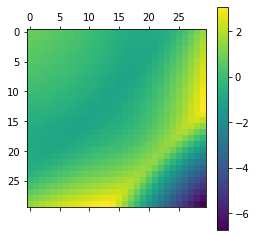

[[ 8.20766401e-01  7.63737631e-01  7.02070284e-01  6.35624027e-01
   5.64290142e-01  4.88039589e-01  4.06706429e-01  3.20057678e-01
   2.28073978e-01  1.30282211e-01  2.63813972e-02 -8.35838318e-02
  -1.99117851e-01 -3.19994640e-01 -4.41404533e-01 -5.51270580e-01
  -6.39025307e-01 -7.02599812e-01 -7.41904259e-01 -7.56062794e-01
  -7.44933033e-01 -7.09255505e-01 -6.48976040e-01 -5.59590721e-01
  -4.01707840e-01 -1.29705238e-01  2.22415829e-01  6.19339466e-01
   1.05337534e+00  1.52248421e+00]
 [ 7.60908031e-01  7.06944227e-01  6.48198414e-01  5.84578514e-01
   5.16038513e-01  4.42335701e-01  3.63331413e-01  2.78772354e-01
   1.88578606e-01  9.22984123e-02 -1.01577759e-02 -1.18702602e-01
  -2.32998848e-01 -3.52818966e-01 -4.73282623e-01 -5.82322311e-01
  -6.69353580e-01 -7.32305813e-01 -7.71080971e-01 -7.84806442e-01
  -7.73299122e-01 -7.37214279e-01 -6.72799110e-01 -5.41697025e-01
  -3.00613213e-01  1.96981430e-02  3.84948444e-01  7.85503197e-01
   1.21983938e+00  1.68903742e+00]
 [ 6.9

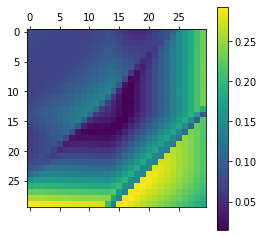

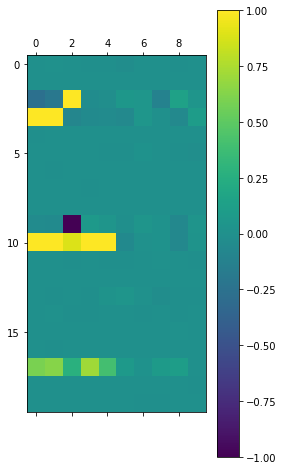

[[], [], [], [], [], [], [], [], [], []]
[[0.3]
 [0.3]
 [0.3]
 [0.2]
 [0.1]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]]
[[], [0, 1, 2], [], [], [2], [0, 1, 2, 3, 4], [], [], [0, 1, 3], []]
[(array([1.5886457]), (0, 1)), (array([0.06975114]), (0, 1, 2)), (array([0.06789502]), (0, 2)), (array([0.05254827]), (1, 2)), (array([0.05158612]), (0, 1, 3)), (array([0.03992557]), (1, 3)), (array([0.03929459]), (2, 3)), (array([0.03901441]), (0, 3)), (array([0.02652998]), (1, 4)), (array([0.02620643]), (0, 4))]


In [ ]:
with tf.Session() as sess:
	init.run()
	for epoch in range(n_epochs):
		for i in range(train_samples_size//batch_size):
			batch_index = np.random.choice(train_samples_size, batch_size, replace=False)
			X_batch = X_train[batch_index, :]
			y_batch = y_train[batch_index]
			sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
		if epoch % 5 == 0:
			acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
			acc_test = accuracy.eval(feed_dict={X:X_test, y:y_test})
			print (epoch, 'train error:', np.sqrt(acc_train), 'test error:', np.sqrt(acc_test))
		if epoch > n_epochs - test_cnt - 1:
			m_logits = logits.eval(feed_dict={X:X_test})
			m_errs = m_errs + (np.transpose(m_logits) - y_test)
			test_errs[n_epochs - epoch - 1] = accuracy.eval(feed_dict={X:X_test, y:y_test})
			iXtest = X_test.copy()
			m_interactions[n_epochs - epoch - 1, :, :] = get_2importance(iXtest, 3*nums, simu, [0, 1])

			iXtest = X_test.copy()
			m_intstrength[n_epochs - epoch - 1, 0] = get_2interactions(iXtest, nums, simu, [0, 1])
			for pid in range(0, 5):
				iXtest = X_test.copy()
				m_intstrength[n_epochs - epoch - 1, pid + 1] = get_1interaction(iXtest, nums, simu, pid)
	save_path = saver.save(sess, './my_f7_model_final.ckpt')

	print (epoch, 'train error:', np.sqrt(acc_train), 'test error:', np.sqrt(acc_test))
	hm_errs = np.mean(test_errs)
	hvar_err = np.mean(np.power(test_errs, 2)) - np.power(hm_errs, 2)
	print (epoch, 'test mean loglikelihood:', -0.5 *np.log(2*np.pi) - 0.5 * hm_errs, 'test standard deviation by neg loglikelihood', 0.5 * np.sqrt(hvar_err))
	m_errs = m_errs * 1.0 / test_cnt
	mean_err = np.mean(np.power(m_errs, 2))
	var_err = 1.0 / test_samples_size * (np.mean(np.power(m_errs, 4)) - np.power(mean_err, 2))
	tvar_err = np.sqrt(mean_err) - np.sqrt(mean_err - np.sqrt(var_err))
	print (epoch, 'test mean error:', np.sqrt(mean_err), 'test variance', tvar_err)
	print (np.mean(m_intstrength, 0))
	print (np.std(m_intstrength,0))

	print (m_interactions.shape)
	mean_int = np.mean(m_interactions, 0)
	std_int = np.std(m_interactions, 0)
	plt.matshow(mean_int)
	plt.colorbar()
	plt.show()
	df = pd.DataFrame(mean_int)
	df.to_csv("mean_interaction.csv")
	print (mean_int)
	plt.matshow(std_int)
	plt.colorbar()
	plt.show()
	#print (std_int)
	dt = pd.DataFrame(std_int)
	dt.to_csv("mean_deviation.csv")
	W_mat = W_rcat.eval()
	plt.matshow(W_mat)
	plt.colorbar()
	plt.clim(-1, 1)
	plt.show()
	#print (W_mat)
	interaction_pruned = [[], [], [], [], [], [], [], [], [], []]
	fraction_score = np.zeros((n_variables, 1))
	print (interaction_pruned)
	for i in range(n_variables):
		isum = 0
		for j in range(int(n_hiddens//2)):
			if ((np.abs(W_mat[2*j, i]) >= thresh) or (np.abs(W_mat[2*j + 1, i]) >= thresh)):
				isum = isum + 1
				interaction_pruned[j].append(i)
		fraction_score[i] = isum * 1.0 / int(n_hiddens//2)
	print (fraction_score)
	print (interaction_pruned)
	iXtest = X_test.copy()
	variance_order(iXtest, nums, simu)
	pairset = {}
	for ele in interaction_pruned:
		if tuple(ele) not in pairset:
			iXtest = X_test.copy()
			if len(ele) == 2:
				val = get_2interactions(iXtest, nums, simu, ele)
				pairset[tuple(ele)] = val
			elif len(ele) == 3:
				val = get_3interactions(iXtest, nums, simu, ele)
				pairset[tuple(ele)] = val
			elif len(ele) == 4:
				val = 0
				#val = get_4interactions(iXtest, nums, simu, ele)
				pairset[tuple(ele)] = val
	for i in range(int(n_hiddens//2)):
		if (len(interaction_pruned[i]) > 5):
			print ("Wow, more than 5 interactions")
		if (len(interaction_pruned[i]) > 1):
			p_subset = list(itertools.combinations(interaction_pruned[i], 2))
			for st in p_subset:
				if (len(pairset) >= conncnt):
					break
				if (tuple(st) not in pairset) and len(pairset) < conncnt:
					iXtest = X_test
					val = get_2interactions(iXtest, nums, simu, st)
					pairset[tuple(st)] = val
		if (len(interaction_pruned[i]) > 2):
			p_subset = list(itertools.combinations(interaction_pruned[i], 3))
			for st in p_subset:
				if (len(pairset) >= conncnt):
					break
				if (tuple(st) not in pairset) and len(pairset) < conncnt:
					iXtest = X_test
					val = get_3interactions(iXtest, nums, simu, st)
					pairset[tuple(st)] = val
		if (len(interaction_pruned[i]) > 3):
			p_subset = list(itertools.combinations(interaction_pruned[i], 4))
			for st in p_subset:
				if len(pairset) >= conncnt:
					break
				if (tuple(st) not in pairset) and len(pairset) < conncnt:
					iXtest = X_test
					val = 0
					#val = get_4interactions(iXtest, nums, simu, st)
					pairset[tuple(st)] = val
	lstrength = sorted( ((v,k) for k,v in pairset.items()), reverse=True)
	print (lstrength)